# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

import pitszi
import minot
from pitszi import physics_main as phys

import macsj0717_libs as libs

# Parameters

In [2]:
base = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

In [81]:
cl_redshift = 0.546
cl_M500     = 26.5*1e14*u.Msun

Tgas = 15*u.keV
cs = phys.sound_speed(Tgas)
print(cs)

1981.3508758974326 km / s


In [4]:
pars1 = np.load(base+'Pk_constraint_RM1_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars2 = np.load(base+'Pk_constraint_RM2_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars3 = np.load(base+'Pk_constraint_RM3_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars4 = np.load(base+'Pk_constraint_RM4_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars5 = np.load(base+'Pk_constraint_RM5_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)

plist1, popt1, pcov1 = pars1[0], pars1[1], pars1[2].reshape(4,4)
plist2, popt2, pcov2 = pars2[0], pars2[1], pars2[2].reshape(4,4)
plist3, popt3, pcov3 = pars3[0], pars3[1], pars3[2].reshape(4,4)
plist4, popt4, pcov4 = pars4[0], pars4[1], pars4[2].reshape(4,4)
plist5, popt5, pcov5 = pars5[0], pars5[1], pars5[2].reshape(4,4)

# Analysis

In [5]:
cl_model = pitszi.Model(name='Model', redshift=cl_redshift, M500=cl_M500, silent=True, output_dir=base)
cl_model.set_pressure_profile_universal_param('A10MD')

In [23]:
parlist = [popt1, popt2, popt3, popt4, popt5]
ell = [False, False, True, True, True]
for ipars in range(len(parlist)):
    pars = parlist[ipars]
    cl_model.model_pressure_fluctuation['Norm'] = pars[0]
    cl_model.model_pressure_fluctuation['Linj'] = pars[1]*u.kpc
    k, pk = cl_model.get_pressure_fluctuation_spectrum()    
    Akpeak = np.amax(np.sqrt(4*np.pi*k**3*pk).to_value(''))
    
    print('Apeak', Akpeak)
    M3d = phys.Apeak_to_M3d_G13(Akpeak, Linj=cl_model.model_pressure_fluctuation['Linj'])
    print('M3d G14', M3d)
    M3d, Merr = phys.sigma_to_M3d_Z23(cl_model.model_pressure_fluctuation['Norm'], state='unrelaxed', ell=ell[ipars], ret_err=True)
    print('M3d Z23', M3d, Merr)
    sigma_v = phys.sigma_v(cs, M3d)
    print('sigma_v Z23', sigma_v, sigma_v*Merr/M3d)
    X_l = phys.Eturb_over_Etherm(M3d-Merr)
    X_c = phys.Eturb_over_Etherm(M3d)
    X_u = phys.Eturb_over_Etherm(M3d+Merr)
    Eratio_l = 1/(1+1/X_l)
    Eratio_c = 1/(1+1/X_c)
    Eratio_u = 1/(1+1/X_u)
    print('Ek/Eth ', Eratio_c, '+', Eratio_u-Eratio_c, '-', Eratio_c-Eratio_l)
    print('')
    

Apeak 0.6948720098096717
M3d G14 0.9378125924269326
M3d Z23 0.8802313324608223 0.17604626649216445
sigma_v Z23 1744.0471215636144 km / s 348.80942431272285 km / s
Ek/Eth  0.3009185305421207 + 0.08173874130280678 - 0.08493279089365888

Apeak 0.4010960770790296
M3d G14 0.8442215356732934
M3d Z23 0.6242805866446457 0.12485611732892914
sigma_v Z23 1236.9188871541319 km / s 247.3837774308264 km / s
Ek/Eth  0.1779794395340854 + 0.059698191507468995 - 0.056274656570499196

Apeak 0.3801687946111237
M3d G14 0.8024723472972392
M3d Z23 0.6009679499587897 0.20032264998626323
sigma_v Z23 1190.7283740371324 km / s 396.90945801237746 km / s
Ek/Eth  0.167114911878101 + 0.09580446093507455 - 0.08524024079744971

Apeak 0.4412148714083557
M3d G14 0.9946870979933956
M3d Z23 0.6657662482531438 0.22192208275104794
sigma_v Z23 1319.116539119314 km / s 439.70551303977135 km / s
Ek/Eth  0.1975908815672139 + 0.1068888106007764 - 0.09894397333670416

Apeak 0.21371050503615457
M3d G14 0.4420114873910868
M3d Z23 0

# Comparison with X-ray fluctuations

In [77]:
cl_model = pitszi.Model(name='Model', redshift=cl_redshift, M500=cl_M500, silent=True, output_dir=base)
cl_model.set_pressure_profile_universal_param('A10MD')

0.6948720098096717
[0.45735553]
0.4010960770790296
[0.40089652]
0.3801687946111237
[0.37984689]
0.4412148714083557
[0.42363621]
0.21371050503615457
[0.21364037]


(0.1, 1)

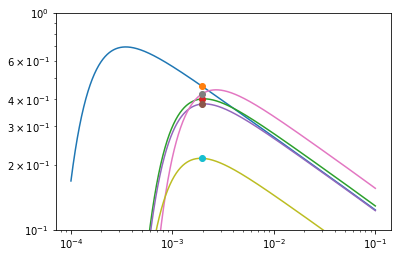

In [63]:
for pars in [popt1, popt2, popt3, popt4, popt5]:
    cl_model.model_pressure_fluctuation['Norm'] = pars[0]
    cl_model.model_pressure_fluctuation['Linj'] = pars[1]*u.kpc
    k,pk = cl_model.get_pressure_fluctuation_spectrum()
    k2500,pk2500 = cl_model.get_pressure_fluctuation_spectrum(1/(507*u.kpc))
    plt.loglog(k.to_value('kpc-1'), np.sqrt(4*np.pi*k**3*pk).to_value(''))
    plt.plot(k2500.to_value('kpc-1'), np.sqrt(4*np.pi*k2500**3*pk2500).to_value(''), marker='o', ls='')
    print(np.amax(np.sqrt(4*np.pi*k**3*pk).to_value('')))
    print(np.sqrt(4*np.pi*k2500**3*pk2500).to_value(''))
plt.ylim(0.1,1)

In [76]:
dpp = np.array([0.45735553, 0.40089652, 0.37984689, 0.42363621, 0.21364037])
gamma_c = dpp/ 32.9*100
gamma_l = dpp/(32.9+16.4)*100
gamma_u = dpp/(32.9-11.0)*100

print(gamma_c)
print(-(gamma_c-gamma_l))
print(gamma_u-gamma_c)

5/3

[1.39013839 1.21853046 1.15454982 1.28764805 0.64936283]
[-0.46243955 -0.40535293 -0.38406931 -0.4283454  -0.21601522]
[0.69824303 0.61204726 0.57991087 0.64676386 0.32616398]


1.6666666666666667

# Extracting kSZ los velocity rms

In [28]:
vz_map_file1 = '/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/MACSJ0717_vz_F1_alt.fits'
vz_map_file2 = '/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/MACSJ0717_vz_F2_alt.fits'
vz_map_file3 = '/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/MACSJ0717_vz_via_leff.fits'

hdul1 = fits.open(vz_map_file1)[0]
hdul2 = fits.open(vz_map_file2)[0]
hdul3 = fits.open(vz_map_file3)[0]

w1 = (hdul1.data < 10000) * (hdul1.data > -10000) * (~np.isnan(hdul1.data))
w2 = (hdul2.data < 10000) * (hdul2.data > -10000) * (~np.isnan(hdul2.data))
w3 = (hdul3.data < 10000) * (hdul3.data > -10000) * (~np.isnan(hdul3.data))

print(np.std(hdul1.data[w1]))
print(np.std(hdul2.data[w2]))
print(np.std(hdul3.data[w3]))

1554.9618
1314.7079
1204.4984734137897


# NT profiles

In [82]:
cl_model = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
cl_model.set_pressure_gas_universal_param('A10MD')

radius = np.logspace(1,4,100)

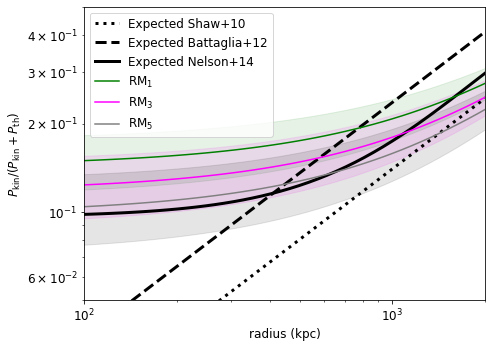

In [100]:
case='sum'

M3d_r1, M3d_r_err1 = phys.sigma_rad_to_M3d_Z23(popt1[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r2, M3d_r_err2 = phys.sigma_rad_to_M3d_Z23(popt2[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r3, M3d_r_err3 = phys.sigma_rad_to_M3d_Z23(popt3[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r4, M3d_r_err4 = phys.sigma_rad_to_M3d_Z23(popt4[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r5, M3d_r_err5 = phys.sigma_rad_to_M3d_Z23(popt5[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)

X_l1 = phys.Eturb_over_Etherm(M3d_r1 - M3d_r_err1)
X_c1 = phys.Eturb_over_Etherm(M3d_r1)
X_u1 = phys.Eturb_over_Etherm(M3d_r1 + M3d_r_err1)
Eratio_l1 = 1/(1+1/X_l1)
Eratio_c1 = 1/(1+1/X_c1)
Eratio_u1 = 1/(1+1/X_u1)

X_l2 = phys.Eturb_over_Etherm(M3d_r2 - M3d_r_err2)
X_c2 = phys.Eturb_over_Etherm(M3d_r2)
X_u2 = phys.Eturb_over_Etherm(M3d_r2 + M3d_r_err2)
Eratio_l2 = 1/(1+1/X_l2)
Eratio_c2 = 1/(1+1/X_c2)
Eratio_u2 = 1/(1+1/X_u2)

X_l3 = phys.Eturb_over_Etherm(M3d_r3 - M3d_r_err3)
X_c3 = phys.Eturb_over_Etherm(M3d_r3)
X_u3 = phys.Eturb_over_Etherm(M3d_r3 + M3d_r_err3)
Eratio_l3 = 1/(1+1/X_l3)
Eratio_c3 = 1/(1+1/X_c3)
Eratio_u3 = 1/(1+1/X_u3)

X_l4 = phys.Eturb_over_Etherm(M3d_r4 - M3d_r_err4)
X_c4 = phys.Eturb_over_Etherm(M3d_r4)
X_u4 = phys.Eturb_over_Etherm(M3d_r4 + M3d_r_err4)
Eratio_l4 = 1/(1+1/X_l4)
Eratio_c4 = 1/(1+1/X_c4)
Eratio_u4 = 1/(1+1/X_u4)

X_l5 = phys.Eturb_over_Etherm(M3d_r5 - M3d_r_err5)
X_c5 = phys.Eturb_over_Etherm(M3d_r5)
X_u5 = phys.Eturb_over_Etherm(M3d_r5 + M3d_r_err5)
Eratio_l5 = 1/(1+1/X_l5)
Eratio_c5 = 1/(1+1/X_c5)
Eratio_u5 = 1/(1+1/X_u5)

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.plot(radius, phys.pnt_over_ptot_r_S10(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls=':',  label='Expected Shaw+10')
plt.plot(radius, phys.pnt_over_ptot_r_B11(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='--', label='Expected Battaglia+12')
plt.plot(radius, phys.pnt_over_ptot_r_N14(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='-',  label='Expected Nelson+14')

plt.plot(radius, Eratio_c1, color='green', label='RM$_1$')
plt.fill_between(radius, Eratio_l1, Eratio_u1, color='green', alpha=0.1)

#plt.plot(radius, Eratio_c2, color='orange', label='RM$_2$')
#plt.fill_between(radius, Eratio_l2, Eratio_u2, color='orange', alpha=0.1)

plt.plot(radius, Eratio_c3, color='magenta', label='RM$_3$')
plt.fill_between(radius, Eratio_l3, Eratio_u3, color='magenta', alpha=0.1)

#plt.plot(radius, Eratio_c4, color='blue', label='RM$_4$')
#plt.fill_between(radius, Eratio_l4, Eratio_u4, color='blue', alpha=0.1)

plt.plot(radius, Eratio_c5, color='grey', label='RM$_5$')
plt.fill_between(radius, Eratio_l5, Eratio_u5, color='k', alpha=0.1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,2000)
plt.ylim(0.05,0.5)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$P_{\rm kin} / \left(P_{\rm kin} + P_{\rm th}\right)$')

plt.savefig(base+'NT_phys_sum.pdf')

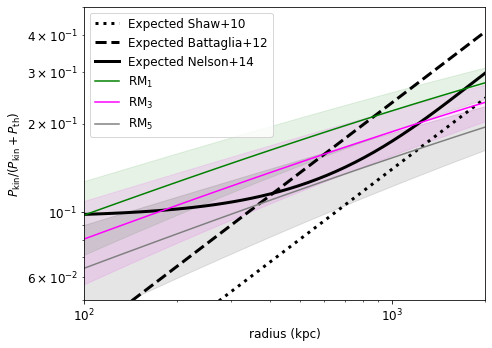

In [101]:
case='prod'

M3d_r1, M3d_r_err1 = phys.sigma_rad_to_M3d_Z23(popt1[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r2, M3d_r_err2 = phys.sigma_rad_to_M3d_Z23(popt2[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r3, M3d_r_err3 = phys.sigma_rad_to_M3d_Z23(popt3[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r4, M3d_r_err4 = phys.sigma_rad_to_M3d_Z23(popt4[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
M3d_r5, M3d_r_err5 = phys.sigma_rad_to_M3d_Z23(popt5[0], radius*u.kpc, cl_model.R500, state='unrelaxed', case=case, ret_err=True)

X_l1 = phys.Eturb_over_Etherm(M3d_r1 - M3d_r_err1)
X_c1 = phys.Eturb_over_Etherm(M3d_r1)
X_u1 = phys.Eturb_over_Etherm(M3d_r1 + M3d_r_err1)
Eratio_l1 = 1/(1+1/X_l1)
Eratio_c1 = 1/(1+1/X_c1)
Eratio_u1 = 1/(1+1/X_u1)

X_l2 = phys.Eturb_over_Etherm(M3d_r2 - M3d_r_err2)
X_c2 = phys.Eturb_over_Etherm(M3d_r2)
X_u2 = phys.Eturb_over_Etherm(M3d_r2 + M3d_r_err2)
Eratio_l2 = 1/(1+1/X_l2)
Eratio_c2 = 1/(1+1/X_c2)
Eratio_u2 = 1/(1+1/X_u2)

X_l3 = phys.Eturb_over_Etherm(M3d_r3 - M3d_r_err3)
X_c3 = phys.Eturb_over_Etherm(M3d_r3)
X_u3 = phys.Eturb_over_Etherm(M3d_r3 + M3d_r_err3)
Eratio_l3 = 1/(1+1/X_l3)
Eratio_c3 = 1/(1+1/X_c3)
Eratio_u3 = 1/(1+1/X_u3)

X_l4 = phys.Eturb_over_Etherm(M3d_r4 - M3d_r_err4)
X_c4 = phys.Eturb_over_Etherm(M3d_r4)
X_u4 = phys.Eturb_over_Etherm(M3d_r4 + M3d_r_err4)
Eratio_l4 = 1/(1+1/X_l4)
Eratio_c4 = 1/(1+1/X_c4)
Eratio_u4 = 1/(1+1/X_u4)

X_l5 = phys.Eturb_over_Etherm(M3d_r5 - M3d_r_err5)
X_c5 = phys.Eturb_over_Etherm(M3d_r5)
X_u5 = phys.Eturb_over_Etherm(M3d_r5 + M3d_r_err5)
Eratio_l5 = 1/(1+1/X_l5)
Eratio_c5 = 1/(1+1/X_c5)
Eratio_u5 = 1/(1+1/X_u5)

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.plot(radius, phys.pnt_over_ptot_r_S10(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls=':',  label='Expected Shaw+10')
plt.plot(radius, phys.pnt_over_ptot_r_B11(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='--', label='Expected Battaglia+12')
plt.plot(radius, phys.pnt_over_ptot_r_N14(radius*u.kpc, cl_model.R500, cl_model.redshift), color='k', lw=3, ls='-',  label='Expected Nelson+14')

plt.plot(radius, Eratio_c1, color='green', label='RM$_1$')
plt.fill_between(radius, Eratio_l1, Eratio_u1, color='green', alpha=0.1)

#plt.plot(radius, Eratio_c2, color='orange', label='RM$_2$')
#plt.fill_between(radius, Eratio_l2, Eratio_u2, color='orange', alpha=0.1)

plt.plot(radius, Eratio_c3, color='magenta', label='RM$_3$')
plt.fill_between(radius, Eratio_l3, Eratio_u3, color='magenta', alpha=0.1)

#plt.plot(radius, Eratio_c4, color='blue', label='RM$_4$')
#plt.fill_between(radius, Eratio_l4, Eratio_u4, color='blue', alpha=0.1)

plt.plot(radius, Eratio_c5, color='grey', label='RM$_5$')
plt.fill_between(radius, Eratio_l5, Eratio_u5, color='k', alpha=0.1)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,2000)
plt.ylim(0.05,0.5)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$P_{\rm kin} / \left(P_{\rm kin} + P_{\rm th}\right)$')

plt.savefig(base+'NT_phys_prod.pdf')